# NASDAQ 100 Prediction with World News

**Is it possible to predict the NDX stock's ups & downs with worldwide news?**

# Method 1 - using topics as inputs

## Data Collection

My data will be composed from:
1. **NDX** historical prices in a a span of 5 years from August 8th 2008 to July 1st 2016.
2. Top 25 posts from **r\worldnews** subreddit from August 8th 2008 to July 1st 2016.


In [105]:
#relevant libraries
#time tracking
from tqdm import tqdm

#plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
from wordcloud import WordCloud, STOPWORDS

#linear algebra and data frames related
import pandas as pd
import numpy as np
import random

#timeseries related
import datetime as dt
from sklearn.model_selection import TimeSeriesSplit

#string related
import re
import string

#dimetional reductions algorithems
from sklearn import decomposition
from sklearn.decomposition import LatentDirichletAllocation, NMF

#preprocessing related
from sklearn.preprocessing import StandardScaler

#pipeline tools
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from pipelinehelper import PipelineHelper

#corpus creation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

#nlp tools
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import warnings

#ml model related packagees
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
#model evaluations metrics
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.metrics import classification_report, plot_roc_curve

#warning hadle
warnings.filterwarnings("always")
warnings.filterwarnings("ignore")

## NDX historical prices

In [106]:
NDX = pd.read_csv("NDX.csv")
NDX["Stock_change"] =  np.where(NDX['Open']<= NDX['Adj Close'], "up", "down")
NDX.tail(6)

,Date,Open,High,Low,Close,Adj Close,Volume,Stock_change
1983,2016-06-24,4294.799805,4373.149902,4274.540039,4285.700195,4285.700195,4411040000,down
1984,2016-06-27,4247.709961,4249.000000,4179.740234,4201.049805,4201.049805,2659650000,down
1985,2016-06-28,4245.319824,4291.430176,4245.290039,4290.470215,4290.470215,2074090000,up
1986,2016-06-29,4323.330078,4373.959961,4322.359863,4364.740234,4364.740234,2116550000,up
1987,2016-06-30,4378.750000,4417.959961,4359.569824,4417.700195,4417.700195,2171180000,up
1988,2016-07-01,4411.770020,4453.859863,4411.759766,4437.450195,4437.450195,1745130000,up


In [107]:
NDX.shape

(1989, 8)

## r/worldnews

In [108]:
r_news = pd.read_csv("r_news.csv")
r_news.drop("Unnamed: 0",axis = 1, inplace = True)
r_news.head()

,Date,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',"b""The commander of a Navy air reconnaissance s...",...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abraham

In [109]:
#convert date to datetime
r_news["Date"] = pd.to_datetime(r_news["Date"])
r_news["Date"].head()

0   2008-08-08
1   2008-08-11
2   2008-08-12
3   2008-08-13
4   2008-08-14
Name: Date, dtype: datetime64[ns]

In [110]:
r_news.shape

(1989, 26)

## Combined dataset (Reddit + stock change)

In [111]:
#add the ndx trend (up/down)
r_news["Stock_change"] = NDX.iloc[:,-1].values
# remove the Date columns
r_news.set_index("Date",inplace = True)
r_news.head(10)

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,...,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Stock_change
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",up
2008-08-11,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",up
2008-08-12,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man...",up
2008-08-13,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',"b""The commander of a Navy air reconnaissance s...","b""92% of CNN readers: Russia's actions in Geor...",...,b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...,up
2008-08-14,b'All the experts admit that we should legalis...,b'War in South Oseti

In [112]:
#train and test set
train = r_news[r_news.index<=pd.Timestamp('2014-12-31')]
test = r_news[r_news.index>pd.Timestamp('2014-12-31')]
print(f"train shape: {train.shape}\n test shape: {test.shape}")

train shape: (1611, 26)
 test shape: (378, 26)


## Data Cleaning

### fill missing values

the fill of missing values will be an empty string to hold the position of the missing value.

In [113]:
print(f"{train.info()}\n {test.info()}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1611 entries, 2008-08-08 to 2014-12-31
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Top1          1611 non-null   object
 1   Top2          1611 non-null   object
 2   Top3          1611 non-null   object
 3   Top4          1611 non-null   object
 4   Top5          1611 non-null   object
 5   Top6          1611 non-null   object
 6   Top7          1611 non-null   object
 7   Top8          1611 non-null   object
 8   Top9          1611 non-null   object
 9   Top10         1611 non-null   object
 10  Top11         1611 non-null   object
 11  Top12         1611 non-null   object
 12  Top13         1611 non-null   object
 13  Top14         1611 non-null   object
 14  Top15         1611 non-null   object
 15  Top16         1611 non-null   object
 16  Top17         1611 non-null   object
 17  Top18         1611 non-null   object
 18  Top19         1611 non-null   

In [114]:
print(f"before filling:\n\ttrain missing: {train.isna().sum().sum()}\n\t test missing: {test.isna().sum().sum()}\n\n")
train.fillna("", inplace=True)
print(f"after filling:\n\ttrain missing: {train.isna().sum().sum()}\n\t test missing: {test.isna().sum().sum()}\n\n")

before filling:
	train missing: 7
	 test missing: 0


after filling:
	train missing: 0
	 test missing: 0




### clean the text

The method for text cleaning:
1. A function for removing the initial "b"character if it exists.
2. A function that returns  if the token is "valid" or not (for invalid token removal).
3. A function that returns a token to it's lowercase lemmatizaed form.
4. A function combining all those functions.

all the functions implement the spacy's nlp object.

In [115]:
# Creating a spaCy object
nlp = spacy.load('en_core_web_sm')

def no_b(text):
    '''remove the lower case b in the start of the headlines if it exists'''
    return text[1:] if text.startswith("b") else text

def is_token_allowed(token):
    '''
        Only allow valid tokens which are not stop words
        and punctuation symbols or numbers.
    '''
    if (not token or
        token.is_stop or token.is_punct):
        return False
    return True

def preprocess_token(token):
    """
    Reduce token to its lowercase lemmatizaed form
    """
    return token.lemma_.strip().lower()

def text_transformer(text):
    """
    combines all the operations above
    """
    doc = nlp(no_b(text))
    tokens = [preprocess_token(token) for token in doc if is_token_allowed(token)]
    return " ".join(tokens)

In [116]:
#after
text_transformer(train.loc[pd.Timestamp('2008-08-08'), 'Top1'])

'georgia down russian warplane country brink war'

In [117]:
tqdm.pandas() #spacy has a long running time, so mesurments are taken
#for every topic
for col in train.columns.tolist()[:25]:
    #clean the text using the operations we defined above
    print(f"{col} out of 25")
    train[col] = train[col].progress_apply(lambda x:text_transformer(x)) 
    test[col] = test[col].progress_apply(lambda x:text_transformer(x))

Top1 out of 25


100%|███████████████████████████████████████████████████████████████████████████████| 378/378 [00:02<00:00, 129.00it/s]


Top2 out of 25


100%|███████████████████████████████████████████████████████████████████████████████| 378/378 [00:02<00:00, 135.89it/s]


Top3 out of 25


100%|███████████████████████████████████████████████████████████████████████████████| 378/378 [00:02<00:00, 138.19it/s]


Top4 out of 25


100%|███████████████████████████████████████████████████████████████████████████████| 378/378 [00:02<00:00, 139.45it/s]


Top5 out of 25


100%|███████████████████████████████████████████████████████████████████████████████| 378/378 [00:02<00:00, 127.73it/s]


Top6 out of 25


100%|███████████████████████████████████████████████████████████████████████████████| 378/378 [00:02<00:00, 135.68it/s]


Top7 out of 25


100%|███████████████████████████████████████████████████████████████████████████████| 378/378 [00:02<00:00, 141.52it/s]


Top8 out of 25


100%|███████████████████████████████████████████████████████████████████████████████| 378/378 [00:02<00:00, 142.35it/s]


Top9 out of 25


100%|███████████████████████████████████████████████████████████████████████████████| 378/378 [00:02<00:00, 135.67it/s]


Top10 out of 25


100%|███████████████████████████████████████████████████████████████████████████████| 378/378 [00:02<00:00, 145.25it/s]


Top11 out of 25


100%|███████████████████████████████████████████████████████████████████████████████| 378/378 [00:02<00:00, 141.26it/s]


Top12 out of 25


100%|███████████████████████████████████████████████████████████████████████████████| 378/378 [00:02<00:00, 143.97it/s]


Top13 out of 25


100%|███████████████████████████████████████████████████████████████████████████████| 378/378 [00:02<00:00, 140.06it/s]


Top14 out of 25


100%|███████████████████████████████████████████████████████████████████████████████| 378/378 [00:02<00:00, 141.60it/s]


Top15 out of 25


100%|███████████████████████████████████████████████████████████████████████████████| 378/378 [00:02<00:00, 144.59it/s]


Top16 out of 25


100%|███████████████████████████████████████████████████████████████████████████████| 378/378 [00:02<00:00, 148.60it/s]


Top17 out of 25


100%|███████████████████████████████████████████████████████████████████████████████| 378/378 [00:02<00:00, 142.19it/s]


Top18 out of 25


100%|███████████████████████████████████████████████████████████████████████████████| 378/378 [00:02<00:00, 148.18it/s]


Top19 out of 25


100%|███████████████████████████████████████████████████████████████████████████████| 378/378 [00:02<00:00, 147.24it/s]


Top20 out of 25


100%|███████████████████████████████████████████████████████████████████████████████| 378/378 [00:02<00:00, 143.04it/s]


Top21 out of 25


100%|███████████████████████████████████████████████████████████████████████████████| 378/378 [00:02<00:00, 147.05it/s]


Top22 out of 25


100%|███████████████████████████████████████████████████████████████████████████████| 378/378 [00:02<00:00, 148.96it/s]


Top23 out of 25


100%|███████████████████████████████████████████████████████████████████████████████| 378/378 [00:02<00:00, 148.02it/s]


Top24 out of 25


100%|███████████████████████████████████████████████████████████████████████████████| 378/378 [00:02<00:00, 150.72it/s]


Top25 out of 25


100%|███████████████████████████████████████████████████████████████████████████████| 378/378 [00:02<00:00, 146.27it/s]


In [118]:
train.sample(3).sort_index(ascending=True)

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,...,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Stock_change
Date,,,,,,,,,,,,,,,,,,,,,
2010-12-14,relative spanish cameraman kill baghdad use wi...,bbc reporter accuse protester cerebral palsy r...,halliburton bribe way bribery charge,disabled man drag wheelchair police student pr...,disabled protestor pull wheelchair drag street...,daily kos post bail money julian assange micha...,wikileaks julian assange grant bail remain loc...,kosovon human organ harvesting ring uncover,world intelligent man william sidis 18981944 ...,wikileak founder julian assange grant bail,...,tony blairs ex roommate shut inquest death ir...,wikileak protest march ahead sydney today desp...,richard holbrooke right get stop war afghanistan,congressional research report charge wikileak ...,charge determined assange,berlusconi survive confidence vote rioter dema...,billy bragg student protesters suppose generat...,prepare cyber war uk government site brace at...,right wing hooligan terrorize russia soccer fa...,down
2013-09-09,norway money know big challenge oil wealth hug...,obama aide lack irrefutable reasonable doubt e...,58 year old uruguayan man disappear month ago ...,dubai islamic austerity sham couples publicaly...,obama administration deny ap request syria evi...,saddam chemical weapon iran hullabaloo west ex...,russia urge assad chemical weapon,france strengthen separation church state unve...,obama go struggle 100 syria votes house,detection water ice saturn cassini spacecraft,...,u.s. government tap computer network company i...,sudanese woman amira osman hamed refuse cover ...,afghan authority slam nato drone strike kill 1...,public concerned grow use tasers police uk,plan day syria attack,al qaida fighter rebel seize christian village...,german intelligence indicate syrian government...,confidential document reveal formidable lobbyi...,russia push syria surrender chemical weapon,up
2014-09-23,liberia 1st nation africa completely stop cut ...,airstrike way syria,google stop support climate change science den...,netflix refuse crtc demand hand subscriber datum,world wide web inventor slam internet fast lan...,king abdullah jordan offer send jordanian grou...,germany introduce cap rent rise densely popula...,"cdc scientist predict staggering 550,000 1.4 m...",turkey allow girl young 10 cover hair school t...,isis kidnap french tourist algeria threaten ex...,...,hong kong student street mass strike china ref...,xi jinping ask chinese army ready regional war,israel approve intel $ 6 billion investment ch...,coal future world energy mix un warn ahead new...,putin considers throw russia isis fight report,ebola contain senegal nigeria,ukraine drone sniper rifle usa,australia launch airstrike isis,rhino poach kingpin arrest south africa,up


## EDA
### Desciptive Statistics

In [119]:
train.describe(include = "object") #no relevant info

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,...,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Stock_change
count,1611,1611,1611,1611,1611,1611,1611,1611,1611,1611,...,1611,1611,1611,1611,1611,1611,1611,1611,1611,1611
unique,1610,1611,1609,1611,1611,1610,1611,1611,1611,1611,...,1611,1611,1611,1611,1611,1611,1611,1609,1609,2
top,monsanto uprooted germany bans cultivation gm ...,british soldier smuggle heroin afghanistan mod...,success drug decriminalization portugal,north korea internet second black night restor...,norway say china cancel ministerial meeting ap...,delhi police woman deserve rape,jews burn israeli flag ny,3 woman kidnap gangrape man 4 day karachi paki...,army officer accuse sexual abuse follow game t...,cut pakistan aid jail bin laden sting doctor,...,chinas dangerous arrogance | increasingly asse...,pakistan ally hell read foreign policy nuclear...,ex idf chief\ widow reject name east jerusalem...,finland ignore warning prisoner prostitution a...,fukushima nuclear plant leak contaminate water...,mass israeli troop poise invasion gaza,,,,up
freq,2,1,2,1,1,2,1,1,1,1,...,1,1,1,1,1,1,1,3,3,887


### Target varaible bar plot

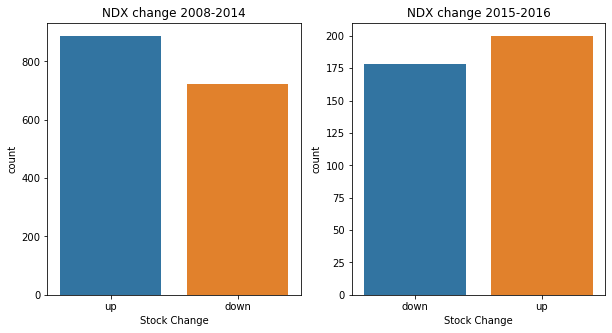

In [120]:
f, axes = plt.subplots(nrows =1 ,ncols = 2, figsize = (10,5))
#2008-2014
sns.countplot(train["Stock_change"], ax = axes[0])
axes[0].set_title("NDX change 2008-2014")
axes[0].set_xlabel("Stock Change")
#2015-2016
sns.countplot(test["Stock_change"],ax = axes[1])
axes[1].set_xlabel("Stock Change")
axes[1].set_title("NDX change 2015-2016");

### Character count

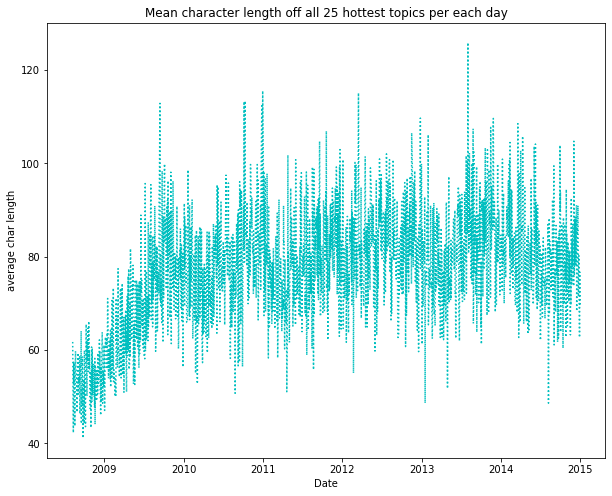

In [121]:
length = [] #empty list
for col in train.columns.tolist()[0:25]:#for all top 25 topics
    length.append(np.array(train[col].str.len().values.tolist())) #append to list each array of str lengths
mean_char = np.mean(length, axis = 0) #mean character length off all 25 hottest topics per each day
date = train.index# date
plt.figure(figsize = (10,8))
plt.ylabel("average char length")
plt.xlabel("Date")
plt.title("Mean character length off all 25 hottest topics per each day")
plt.plot(date, mean_char, 'c:', label='variance') 
plt.show()

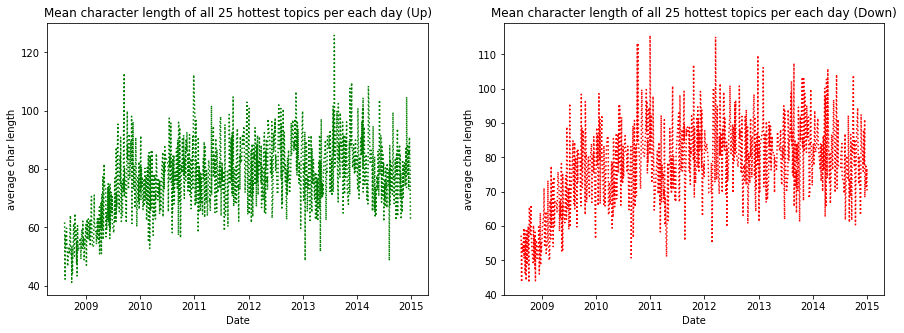

In [122]:
up = train[train["Stock_change"]=="up"]
length_up = [] #empty list
for col in up.columns.tolist()[0:25]:#for all top 25 topics
    length_up.append(np.array(up[col].str.len().values.tolist())) #append to list each array of str lengths
up_char = np.mean(length_up, axis = 0) #mean character length off all 25 hottest topics per each day

down = train[train["Stock_change"]=="down"]
length_down = [] #empty list
for col in down.columns.tolist()[0:25]:#for all top 25 topics
    length_down.append(np.array(down[col].str.len().values.tolist())) #append to list each array of str lengths
down_char = np.mean(length_down, axis = 0) #mean character length off all 25 hottest topics per each day

f, axes = plt.subplots(nrows =1 ,ncols = 2, figsize = (15,5))
axes[0].set_ylabel("average char length")
axes[0].set_xlabel("Date")
axes[0].set_title("Mean character length of all 25 hottest topics per each day (Up)")
axes[0].plot(up.index, up_char, 'g:')

axes[1].set_ylabel("average char length")
axes[1].set_xlabel("Date")
axes[1].set_title("Mean character length of all 25 hottest topics per each day (Down)")
axes[1].plot(down.index, down_char, 'r:');

### Word counts

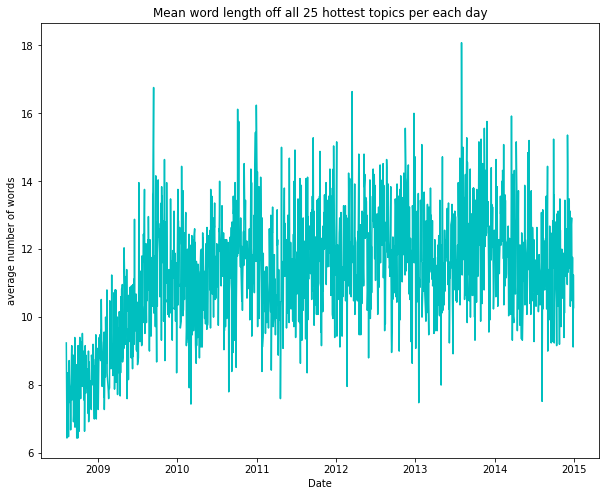

In [123]:
words_num = []
for col in train.columns.tolist()[:25]:
    words_num.append(np.array(train[col].apply(lambda w: len(w.split()))))
mean_word = np.mean(words_num, axis = 0)
date = train.index# date
plt.figure(figsize = (10,8))
plt.ylabel("average number of words")
plt.xlabel("Date")
plt.title("Mean word length off all 25 hottest topics per each day")
plt.plot(date, mean_word, 'c-', label='variance') 
plt.show()

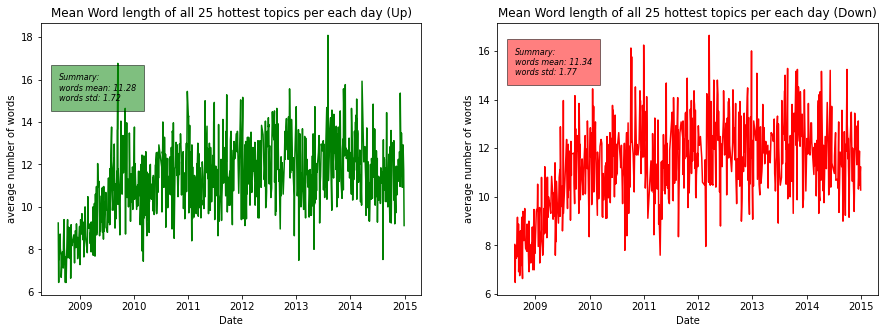

In [124]:
wl_up = [] #word length
for col in up.columns.tolist()[0:25]:#for all top 25 topics
    wl_up.append(np.array(up[col].apply(lambda w: len(w.split())))) #append to list each array of word lengths
up_word = np.mean(wl_up, axis = 0) #mean character length off all 25 hottest topics per each day

wl_down = [] #empty list
for col in down.columns.tolist()[0:25]:#for all top 25 topics
    wl_down.append(np.array(down[col].apply(lambda w: len(w.split())))) #append to list each array of word lengths
down_word = np.mean(wl_down, axis = 0) #mean character length off all 25 hottest topics per each day

f, axes = plt.subplots(nrows =1 ,ncols = 2, figsize = (15,5))
axes[0].set_ylabel("average number of words")
axes[0].set_xlabel("Date")
axes[0].set_title("Mean Word length of all 25 hottest topics per each day (Up)")
txt = f"Summary:\nwords mean: {round(up_word.mean(),2)}\nwords std: {round(up_word.std(),2)}"
axes[0].text(pd.Timestamp('2008-08-14 00:00:00'), 15,txt,size=8,style = 'italic',bbox=dict(facecolor='g',alpha=0.5, edgecolor='black', boxstyle='square,pad=1.0'))
axes[0].plot(up.index, up_word, 'g-')

axes[1].set_ylabel("average number of words")
axes[1].set_xlabel("Date")
axes[1].set_title("Mean Word length of all 25 hottest topics per each day (Down)")
txt = f"Summary:\nwords mean: {round(down_word.mean(),2)}\nwords std: {round(down_word.std(),2)}"
axes[1].text(pd.Timestamp('2008-08-14 00:00:00'), 15,txt,size=8,style = 'italic',bbox=dict(facecolor='r',alpha=0.5, edgecolor='black', boxstyle='square,pad=1.0'))
axes[1].plot(down.index, down_word, 'r-');


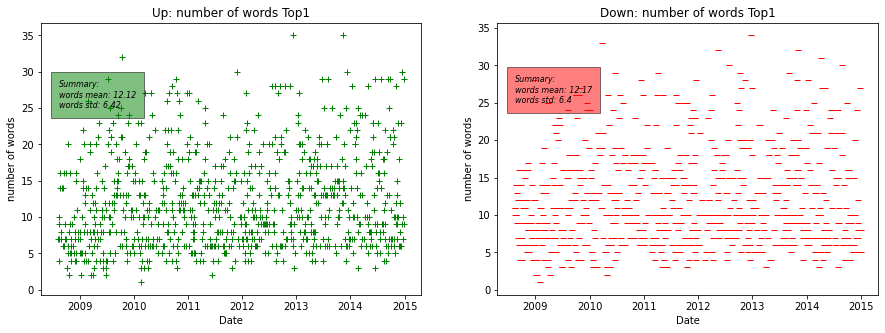

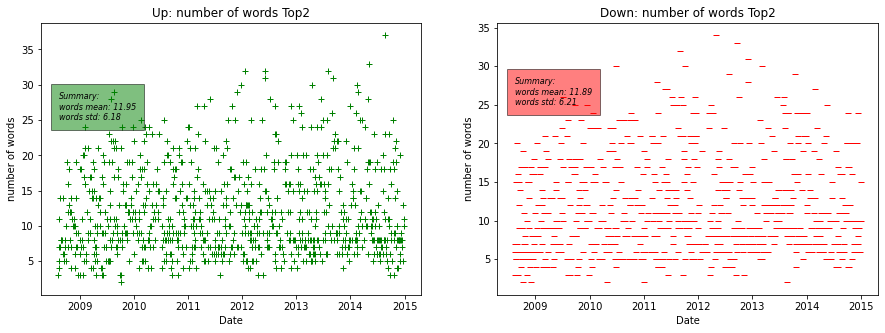

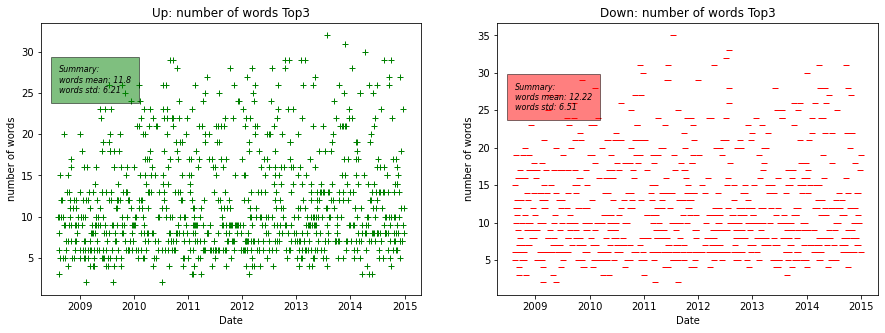

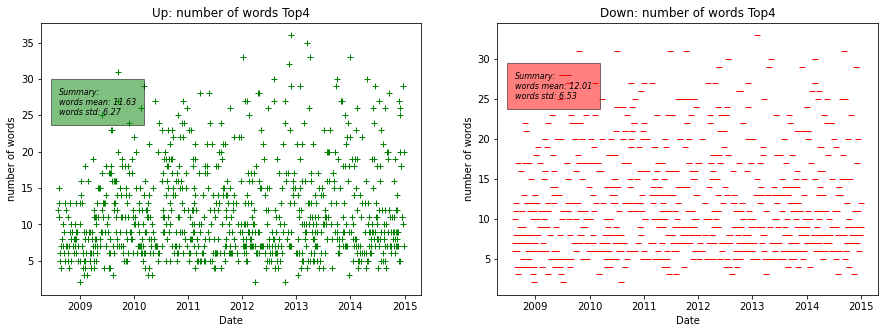

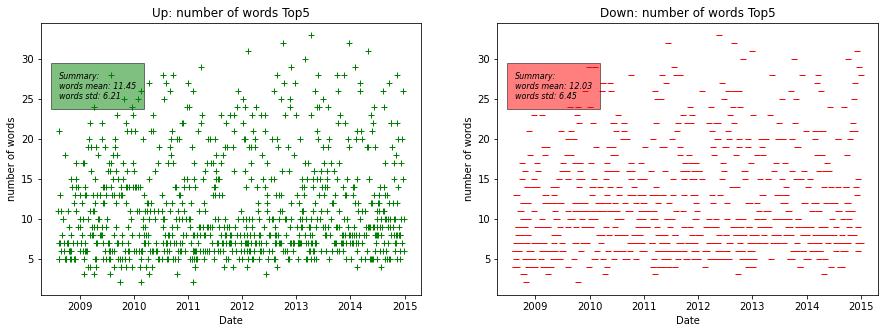

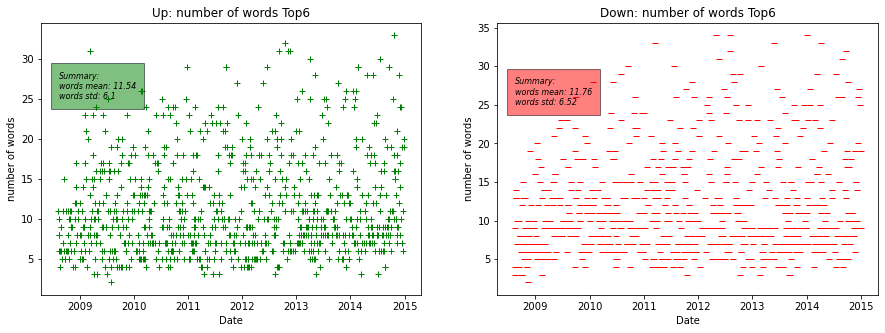

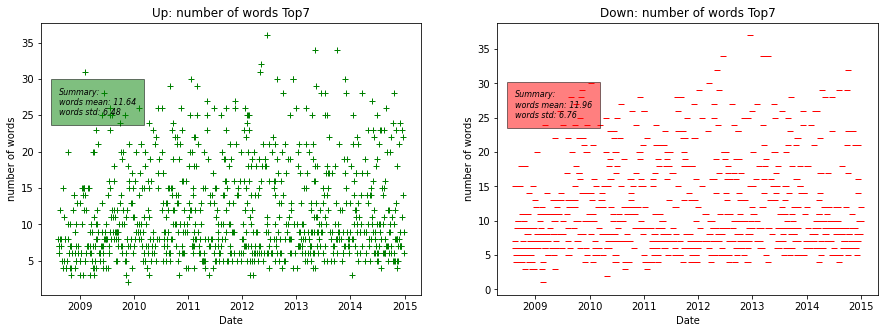

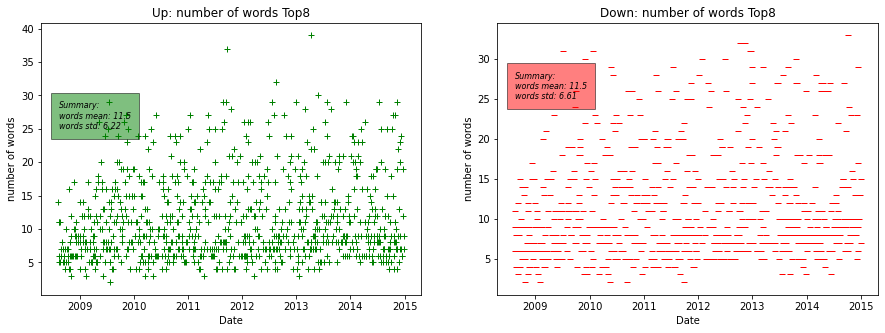

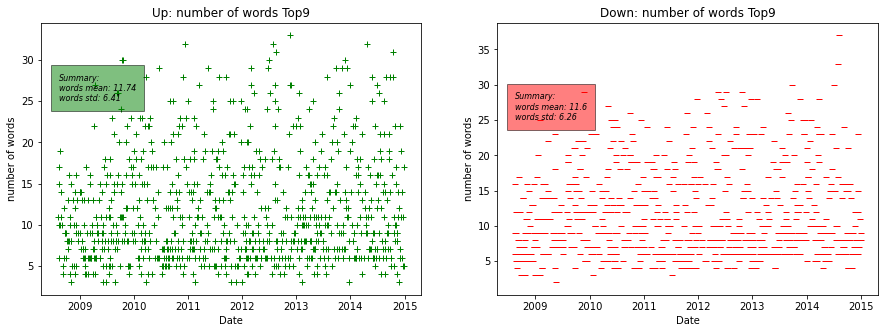

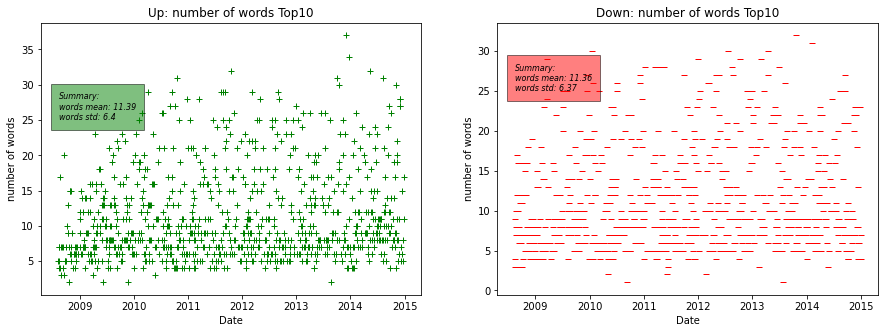

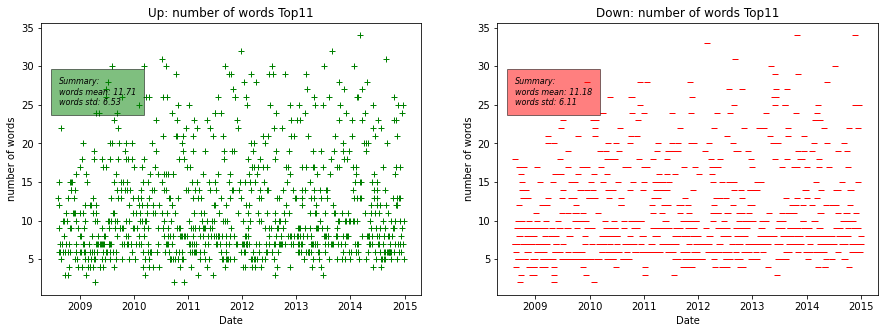

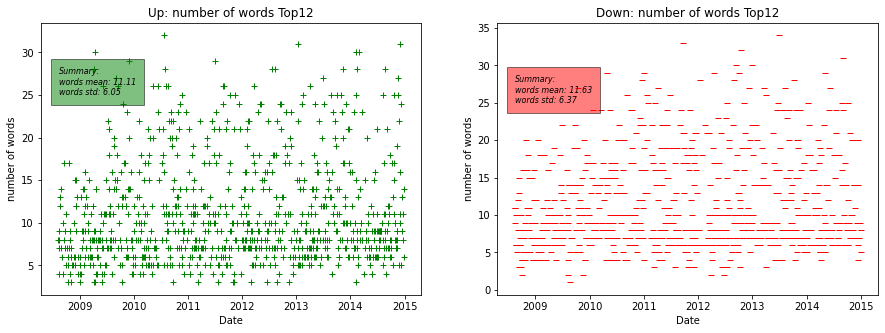

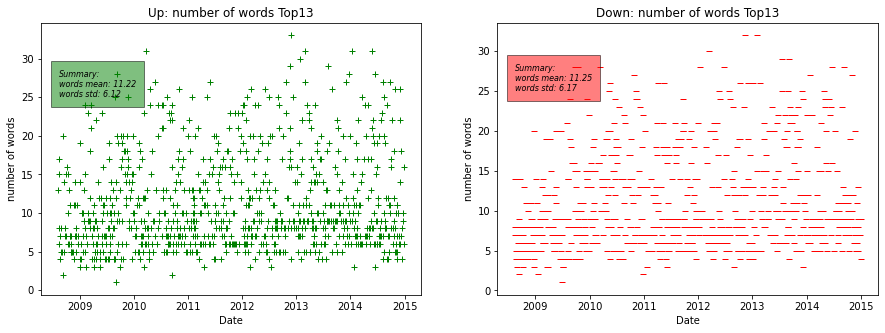

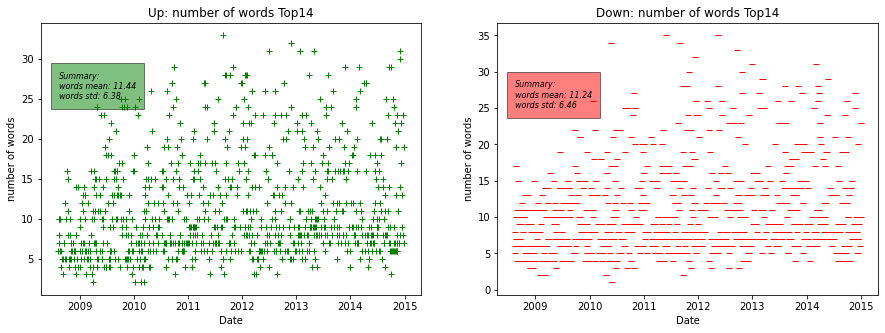

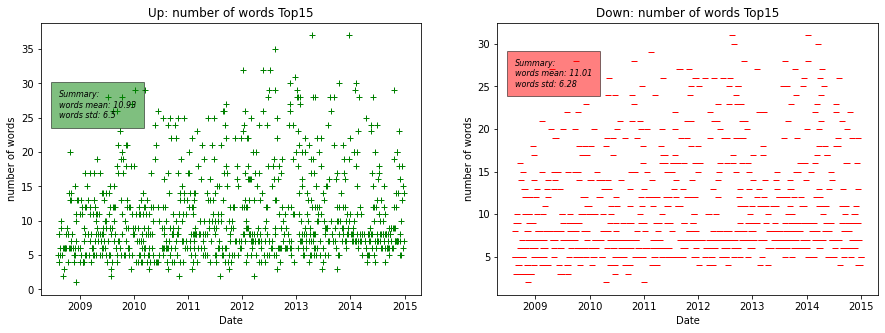

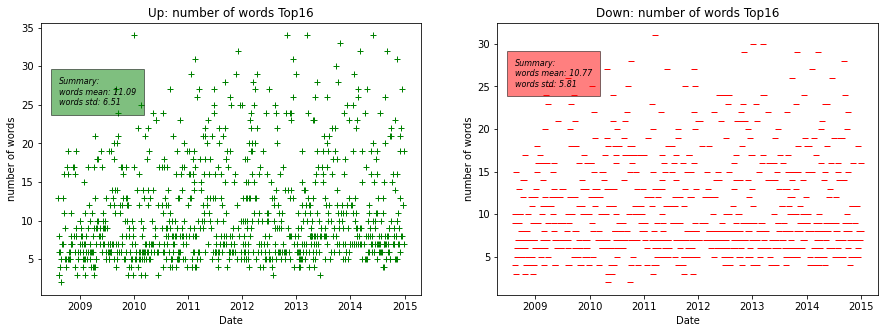

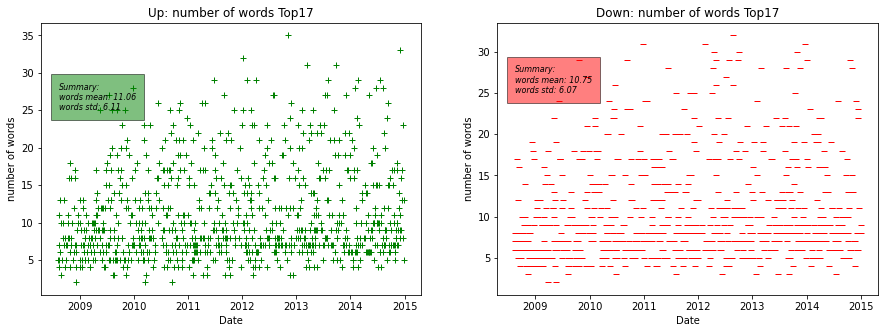

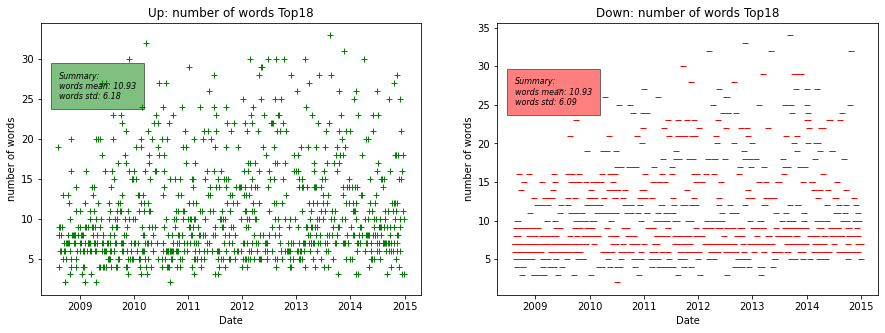

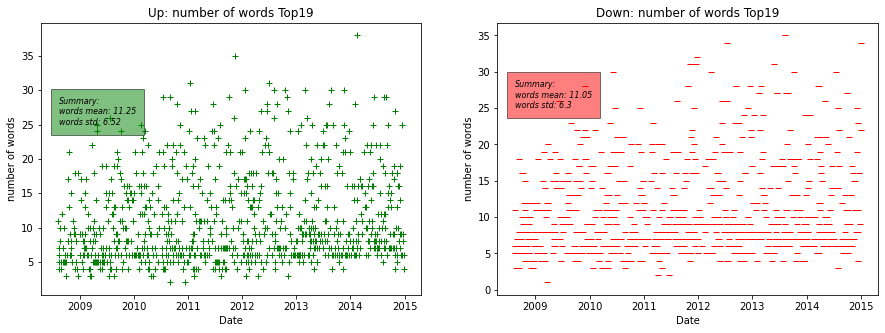

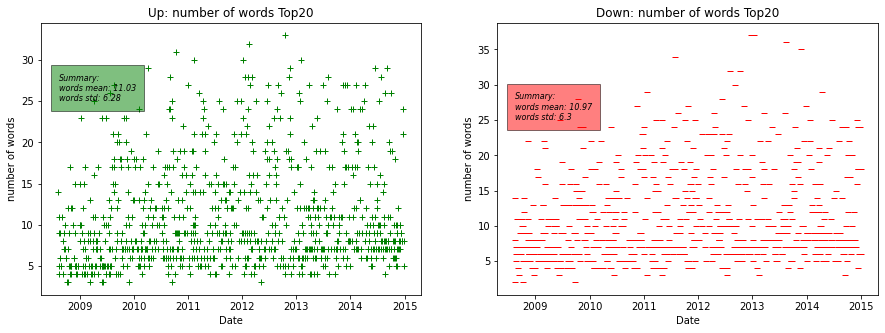

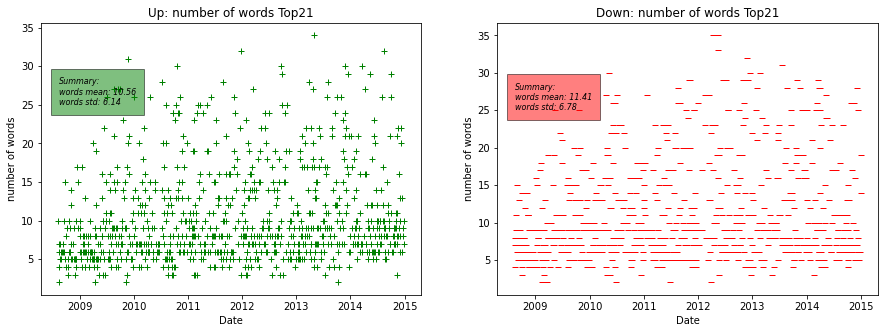

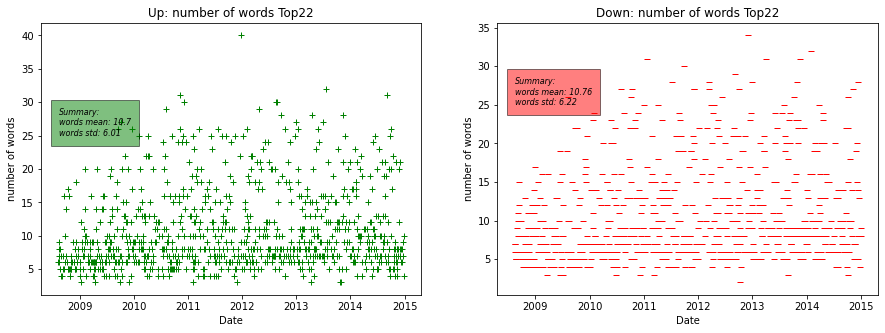

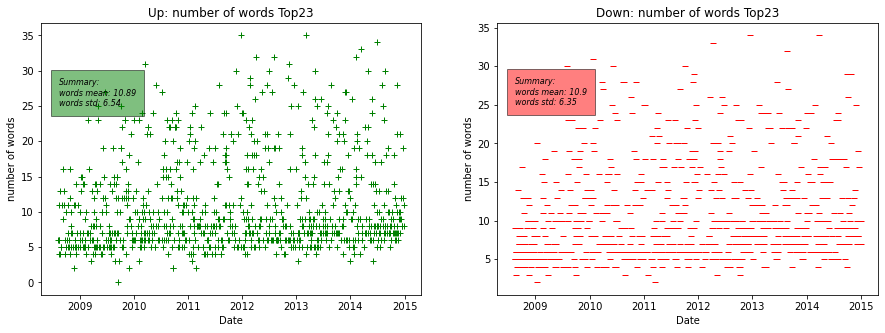

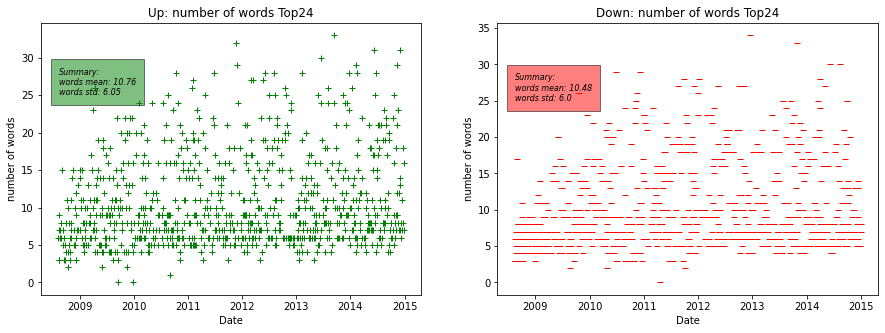

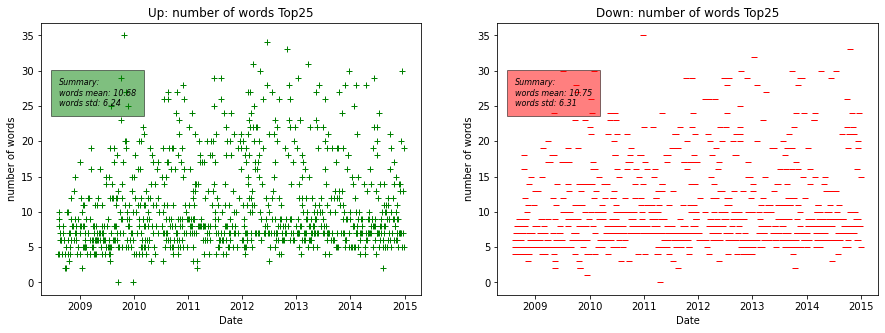

In [125]:
for i in range(25):
    f, axes = plt.subplots(nrows =1 ,ncols = 2, figsize = (15,5))
    
    axes[0].set_ylabel("number of words")
    axes[0].set_xlabel("Date")
    axes[0].set_title(f"Up: number of words Top{i+1}")    
    txt = f"Summary:\nwords mean: {round(wl_up[i].mean(),2)}\nwords std: {round(wl_up[i].std(),2)}"
    axes[0].text(pd.Timestamp('2008-08-14 00:00:00'), 25,txt,size=8,style = 'italic',bbox=dict(facecolor='g',alpha=0.5, edgecolor='black', boxstyle='square,pad=1.0'))
    axes[0].plot(up.index, wl_up[i], 'g+')
    
    axes[1].set_ylabel("number of words")
    axes[1].set_xlabel("Date")
    axes[1].set_title(f"Down: number of words Top{i+1}")
    txt = f"Summary:\nwords mean: {round(wl_down[i].mean(),2)}\nwords std: {round(wl_down[i].std(),2)}"
    axes[1].text(pd.Timestamp('2008-08-14 00:00:00'), 25,txt,size=8,style = 'italic',bbox=dict(facecolor='r',alpha=0.5, edgecolor='black', boxstyle='square,pad=1.0'))
    axes[1].plot(down.index, wl_down[i], 'r_')

### Word Clouds

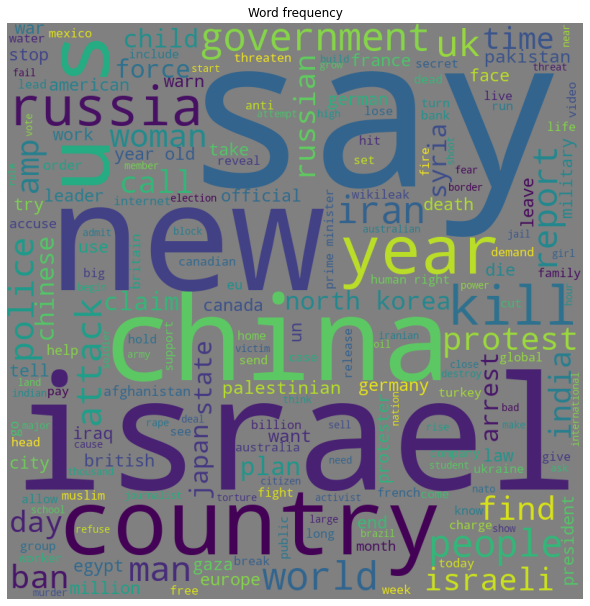

In [126]:
trainheadlines = []
testheadlines = []
for row in range(0,len(train.index)):
    trainheadlines.append(' '.join(str(x) for x in train.iloc[row,0:25]))
for row in range(0,len(test.index)):    
    testheadlines.append(' '.join(str(x) for x in test.iloc[row,0:25]))

comment_words = ''
# iterate through the list
for Doc in trainheadlines:      
    # split the value
    tokens = Doc.split()
    comment_words += " ".join(tokens)
        
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='gray',
                min_font_size = 10).generate(comment_words)
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title("Word frequency")  
plt.show()

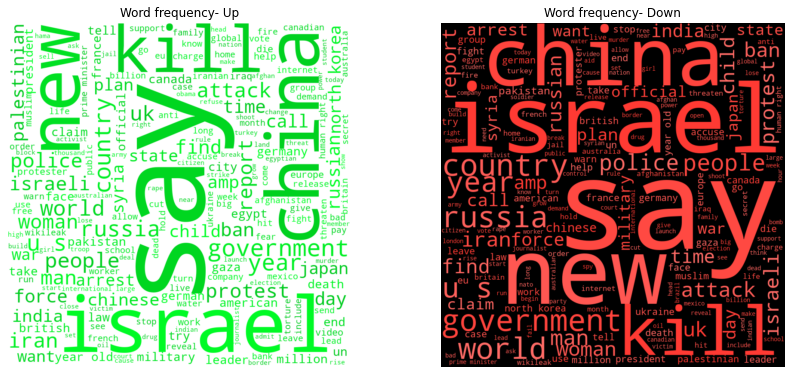

In [127]:
def red_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(2, 100%%, %50d%%)" % random.randint(60, 70)  

def green_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(129, 100%%, %50d%%)" % random.randint(40, 50)  


# up
upheadlines = []
for row in range(len(up.index)):
    upheadlines.append(' '.join(str(x) for x in up.iloc[row,0:25]))
Up_corpus = upheadlines
Up_words = " ".join(Up_corpus)
Up_vocabulary = list(set(Up_words.split(" ")))
up_comment_words = ''
# iterate through the list
for Doc in Up_corpus:      
    # split the value
    tokens = Doc.split()
    up_comment_words += " ".join(tokens)
        
up_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(up_comment_words)

                
#down
downheadlines = []
for row in range(len(down.index)):
    downheadlines.append(' '.join(str(x) for x in down.iloc[row,0:25]))
Down_corpus = downheadlines
Down_words = " ".join(Down_corpus)
Down_vocabulary = list(set(Down_words.split(" ")))
down_comment_words = ''
# iterate through the list
for Doc in Down_corpus:      
    # split the value
    down_tokens = Doc.split()
    down_comment_words += " ".join(down_tokens)
        
down_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                min_font_size = 10).generate(down_comment_words)

f, axes = plt.subplots(nrows =1 ,ncols = 2, figsize = (15,5))
                  

#up plot
axes[0].imshow(up_wordcloud.recolor(color_func=green_color_func, random_state=3)
,interpolation="bilinear")
axes[0].axis("off")
f.tight_layout(pad = 0)
axes[0].set_title("Word frequency- Up")


#down plot
axes[1].imshow(down_wordcloud.recolor(color_func=red_color_func, random_state=3),
interpolation="bilinear")
axes[1].axis("off")
f.tight_layout(pad = 0)
axes[1].set_title("Word frequency- Down");  

## Topic modeling

topic modeling with 2 approaches:
1. Non Negative Matrix Factorization (NMF).
2. Latent Dirichlet Allocation (LDA).

for each approach:
* 10 topics.
* 10 most significant words for each topic.

In [128]:
no_features = 1000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=5, max_features=no_features, ngram_range=(1, 3))
tfidf = tfidf_vectorizer.fit_transform(trainheadlines)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()


# LDA can only use raw term counts because it is a probabilistic graphical model
rc_vectorizer = CountVectorizer(max_df=0.9, min_df=5, max_features=no_features, ngram_range=(1, 3))#rc - raw count
rc = rc_vectorizer.fit_transform(trainheadlines)
rc_feature_names = rc_vectorizer.get_feature_names()

In [129]:
#identifying 10 topics in the headlines
no_topics = 10

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(rc)

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
                        

no_top_words = 10 #number of words for each topic
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
year say world new china police kill government people country
Topic 1:
gaza israel israeli hamas palestinians war palestinian un idf aid
Topic 2:
ukraine russia russian ukrainian putin georgia say nato military pro
Topic 3:
korea north north korea korean south south korea north korean kim missile jong
Topic 4:
libya gaddafi fukushima libyan japan nuclear reactor plant tsunami bahrain
Topic 5:
assange wikileaks julian julian assange wikileak cable founder ecuador sweden leak
Topic 6:
snowden nsa edward edward snowden surveillance spy asylum leak reveal hong kong
Topic 7:
isis ebola islamic state islamic state iraq militant hong kong kong hamas
Topic 8:
egypt mubarak egyptian protest protester jazeera al jazeera square al pro
Topic 9:
bin laden bin laden pakistani pakistan raid death reactor drug intelligence


In [130]:
display_topics(lda, rc_feature_names, no_top_words)

Topic 0:
snowden russia afghan kill putin taliban civilian 90 trial russian
Topic 1:
pirate israel ship attack say arrest zimbabwe israeli arab somali
Topic 2:
say russia world new china russian government people police year
Topic 3:
wall war blame say kill russian georgia death russia crisis
Topic 4:
snowden nsa edward edward snowden surveillance spy asylum intelligence hong kong kong
Topic 5:
israel israeli gaza say year kill war iran government world
Topic 6:
pakistan georgia attack russia zimbabwe people war bomb kill pirate
Topic 7:
year say kill government police new north world china korea
Topic 8:
korea north kim north korea jong kim jong korean north korean iran official
Topic 9:
assange wikileaks julian julian assange wikileak cable founder war georgia russia


# predictions
## models

5 classification models are used for a basic prediction:

In [131]:
random.seed(1)
models = {"Decision Tree":DecisionTreeClassifier(), 
          "Random Forest":RandomForestClassifier(), 
          "Logistic Regression":LogisticRegression(),
          "Gaussian Naive Bayse":GaussianNB(), 
          "Support Vector Machines":SVC()}

train["Stock_change"] = train["Stock_change"].apply(lambda x: 1 if x=="up" else 0)
test["Stock_change"] = test["Stock_change"].apply(lambda x: 1 if x=="up" else 0)

### Raw count corpus prediction

In [132]:
vocab_df = pd.DataFrame(rc.toarray(),train.index, columns = rc_feature_names)
vocab_df.sample()

,000,000 people,10,100,11,12,13,14,15,16,...,wrong,year,year ago,year old,yemen,young,youth,zealand,zimbabwe,zone
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-09,0,0,1,0,0,0,0,0,1,0,...,0,2,0,2,0,0,0,0,0,0


In [133]:

vocab_test =  pd.DataFrame(rc_vectorizer.transform(testheadlines).toarray(),index = test.index, columns = rc_vectorizer.get_feature_names())
vocab_test = vocab_test[vocab_df.columns.tolist()]#use only 

for m,v in models.items():
    v.fit(vocab_df, train["Stock_change"])
    predictions = v.predict(vocab_test)
    print(m,':\n',pd.crosstab(test["Stock_change"], predictions, rownames=["Actual"], colnames=["Predicted"]),"\n")
    print("accuracy score: ",accuracy_score(test["Stock_change"], predictions))
    print("roc auc score: ",roc_auc_score(test["Stock_change"], predictions),"\n")

Decision Tree :
 Predicted   0    1
Actual            
0          67  111
1          89  111 

accuracy score:  0.4708994708994709
roc auc score:  0.4657022471910113 

Random Forest :
 Predicted   0    1
Actual            
0          30  148
1          54  146 

accuracy score:  0.4656084656084656
roc auc score:  0.4492696629213483 

Logistic Regression :
 Predicted    0   1
Actual            
0          101  77
1          117  83 

accuracy score:  0.48677248677248675
roc auc score:  0.4912078651685393 

Gaussian Naive Bayse :
 Predicted    0   1
Actual            
0           79  99
1          103  97 

accuracy score:  0.4656084656084656
roc auc score:  0.46441011235955054 

Support Vector Machines :
 Predicted   0    1
Actual            
0          34  144
1          25  175 

accuracy score:  0.5529100529100529
roc auc score:  0.5330056179775281 



## tf-idf corpus prediction

In [134]:
vocab_df2 = pd.DataFrame(tfidf.toarray(),train.index, columns = tfidf_feature_names)
vocab_df2.sample()

,000,000 people,10,100,11,12,13,14,15,16,...,wrong,year,year ago,year old,yemen,young,youth,zealand,zimbabwe,zone
Date,,,,,,,,,,,,,,,,,,,,,
2013-02-13,0.0,0.0,0.097305,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.026018,0.0,0.0,0.0,0.056876,0.0,0.0,0.0,0.147556


In [135]:
vocab_test =  pd.DataFrame(tfidf_vectorizer.transform(testheadlines).toarray(),index = test.index, columns = tfidf_vectorizer.get_feature_names())
vocab_test = vocab_test[vocab_df2.columns.tolist()]#use only 
for m,v in models.items():
    v.fit(vocab_df2, train["Stock_change"])
    predictions = v.predict(vocab_test)
    print(m,':\n',pd.crosstab(test["Stock_change"], predictions, rownames=["Actual"], colnames=["Predicted"]),"\n")
    print("accuracy score: ",accuracy_score(test["Stock_change"], predictions))
    print("roc auc score: ",roc_auc_score(test["Stock_change"], predictions),"\n")

Decision Tree :
 Predicted    0    1
Actual             
0           75  103
1          103   97 

accuracy score:  0.455026455026455
roc auc score:  0.45317415730337074 

Random Forest :
 Predicted   0    1
Actual            
0          45  133
1          51  149 

accuracy score:  0.5132275132275133
roc auc score:  0.49890449438202245 

Logistic Regression :
 Predicted   0    1
Actual            
0          61  117
1          66  134 

accuracy score:  0.5158730158730159
roc auc score:  0.5063483146067416 

Gaussian Naive Bayse :
 Predicted    0   1
Actual            
0           94  84
1          105  95 

accuracy score:  0.5
roc auc score:  0.5015449438202247 

Support Vector Machines :
 Predicted   0    1
Actual            
0          34  144
1          32  168 

accuracy score:  0.5343915343915344
roc auc score:  0.515505617977528 



## topic modeling (Lda)

**note** A funciton for transforming the headline into it's classified topic is created.
### train lables

In [136]:
def topic_tranformer(text,vectorizer = rc_vectorizer,transformer = lda):
    """
    this function takes a column and vectorizes the words of each rows (raw count as default), 
    transforms with dimension reduction teqnique (lda count as default)
    and takes the indices max of each row as the topic number.
    """
    vec = vectorizer.transform(text)#transform a test column.
    transform = transformer.transform(vec)#use LDA for the topic modeling.
    topic = transform.argmax(axis = 1)#get the topic who scored the highest.
    return(topic)

In [137]:
topic_df = train.copy()
for i in range(25):#for each column
    topic_df[f"Top{i+1}"] = topic_tranformer(topic_df.iloc[:,i])#identify the topic
topic_df.head(2)

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,...,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Stock_change
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,9,0,9,2,7,6,9,7,5,6,...,7,5,2,6,2,6,7,2,9,1
2008-08-11,6,6,6,6,6,2,6,6,8,6,...,6,6,2,9,5,2,6,6,7,1


In [138]:
topic_test = test.copy()
for i in range(25):
    topic_test[f"Top{i+1}"] = topic_tranformer(topic_test.iloc[:,i])#transform the test data 
topic_test.head(2)

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,...,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Stock_change
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,7,5,2,7,5,7,2,2,2,7,...,5,5,7,2,7,2,2,7,2,0
2015-01-05,5,2,7,2,2,7,5,7,5,6,...,7,7,5,2,7,2,2,2,7,0


Predicting using 25 headlines than going down to 1, for each model.
meaning 125 predictions:

In [139]:
for i in range(25,0,-1):
    print(f"top {i} headlines\n","#"*100)
    for m,v in models.items():
        v.fit(topic_df.iloc[:,:25], train["Stock_change"])
        predictions = v.predict(topic_test.iloc[:,:25])
        print(m,':\n',pd.crosstab(test["Stock_change"], predictions, rownames=["Actual"], colnames=["Predicted"]),"\n")
        print("accuracy score: ",accuracy_score(test["Stock_change"], predictions))
        print("roc auc score: ",roc_auc_score(test["Stock_change"], predictions),"\n")

top 25 headlines
 ####################################################################################################
Decision Tree :
 Predicted   0    1
Actual            
0          74  104
1          74  126 

accuracy score:  0.5291005291005291
roc auc score:  0.5228651685393259 

Random Forest :
 Predicted   0    1
Actual            
0          52  126
1          60  140 

accuracy score:  0.5079365079365079
roc auc score:  0.4960674157303371 

Logistic Regression :
 Predicted   0    1
Actual            
0          38  140
1          38  162 

accuracy score:  0.5291005291005291
roc auc score:  0.5117415730337078 

Gaussian Naive Bayse :
 Predicted   0    1
Actual            
0          34  144
1          32  168 

accuracy score:  0.5343915343915344
roc auc score:  0.515505617977528 

Support Vector Machines :
 Predicted   0    1
Actual            
0          51  127
1          55  145 

accuracy score:  0.5185185185185185
roc auc score:  0.5057584269662921 

top 24 headlines
 #

## topic modeling (NMF)
### train lables

In [140]:
topic_df2 = train.copy()
for i in range(25):
    topic_df2[f"Top{i+1}"] = topic_tranformer(topic_df2.iloc[:,i],vectorizer = tfidf_vectorizer,transformer = nmf)#this time, tf-idf and nmf is applied. 
topic_df2.head(2)

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,...,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Stock_change
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,2,0,2,2,0,2,2,0,0,2,...,0,1,0,2,0,2,0,0,0,1
2008-08-11,0,1,1,2,0,0,2,0,0,2,...,2,0,0,3,1,2,2,2,0,1


In [141]:
topic_test2 = test.copy()
for i in range(25):
    topic_test2[f"Top{i+1}"] = topic_tranformer(topic_test2.iloc[:,i],vectorizer = tfidf_vectorizer,transformer = nmf)#this time, tf-idf and nmf is applied. 
topic_test2.head(2)

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,...,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Stock_change
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,0,7,0,0,0,0,0,0,0,0,...,1,1,0,4,0,6,2,0,2,0
2015-01-05,0,8,3,0,0,0,1,0,8,0,...,0,2,0,4,0,2,0,2,0,0


In [142]:
for i in range(25,0,-1):
    print(f"top {i} headlines\n","#"*100)
    for m,v in models.items():    
        v.fit(topic_df2.iloc[:,:i], train["Stock_change"])
        predictions = v.predict(topic_test2.iloc[:,:i])
        print(m,':\n',pd.crosstab(test["Stock_change"], predictions, rownames=["Actual"], colnames=["Predicted"]),"\n")
        print("accuracy score: ",accuracy_score(test["Stock_change"], predictions))
        print("roc auc score: ",roc_auc_score(test["Stock_change"], predictions),"\n")    

top 25 headlines
 ####################################################################################################
Decision Tree :
 Predicted   0    1
Actual            
0          74  104
1          85  115 

accuracy score:  0.5
roc auc score:  0.4953651685393258 

Random Forest :
 Predicted   0    1
Actual            
0          59  119
1          60  140 

accuracy score:  0.5264550264550265
roc auc score:  0.5157303370786517 

Logistic Regression :
 Predicted   0    1
Actual            
0          49  129
1          47  153 

accuracy score:  0.5343915343915344
roc auc score:  0.5201404494382023 

Gaussian Naive Bayse :
 Predicted   0    1
Actual            
0          78  100
1          79  121 

accuracy score:  0.5264550264550265
roc auc score:  0.5216011235955056 

Support Vector Machines :
 Predicted   0    1
Actual            
0          46  132
1          35  165 

accuracy score:  0.5582010582010583
roc auc score:  0.5417134831460674 

top 24 headlines
 ###############

## Time Series Cross Validation

for cross validation we need to use time series dependant cv for accurate prediction with no data leakage.
the splits are printed for clarification.

In [143]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits = 5)
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)

In [144]:
X = pd.concat([topic_df2.iloc[:,:10],topic_test2.iloc[:,:10]])
y = pd.concat([train.iloc[:,25:26],test.iloc[:,25:26]])
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "\nTEST:", test_index)

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

In [145]:

for train_index, test_index in tscv.split(X):
    X_train, X_val = X.iloc[train_index[0]:train_index[-1],:], X.iloc[test_index[0]:test_index[-1],:]
    y_train, y_val = y.iloc[train_index[0]:train_index[-1],:], y.iloc[test_index[0]:test_index[-1],:]
    clf = RandomForestClassifier(random_state = 37)
    grid_values = {'criterion' : ["gini","entropy"],
 'max_depth': [None,4,6],
 'min_samples_leaf': [2,3, None],
 'min_samples_split': [2,3,None],
 'n_estimators': [100, None]}
    grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'balanced_accuracy',n_jobs = -1)
    grid_clf_acc.fit(X_train, y_train)
    y_pred_acc = grid_clf_acc.predict(X_val)                            
    print('Accuracy Score : ' + str(accuracy_score(y_val,y_pred_acc)))
    print('Roc Score : ' + str(roc_auc_score(y_val,y_pred_acc)))
    print(classification_report(y_val,y_pred_acc))

Accuracy Score : 0.5212121212121212
Roc Score : 0.487977632805219
              precision    recall  f1-score   support

           0       0.41      0.21      0.28       145
           1       0.55      0.76      0.64       185

    accuracy                           0.52       330
   macro avg       0.48      0.49      0.46       330
weighted avg       0.49      0.52      0.48       330

Accuracy Score : 0.5121212121212121
Roc Score : 0.48769219396806623
              precision    recall  f1-score   support

           0       0.43      0.18      0.25       152
           1       0.53      0.80      0.64       178

    accuracy                           0.51       330
   macro avg       0.48      0.49      0.44       330
weighted avg       0.48      0.51      0.46       330

Accuracy Score : 0.5818181818181818
Roc Score : 0.554710964440654
              precision    recall  f1-score   support

           0       0.58      0.28      0.37       149
           1       0.58      0.83    

# Method 2 - Using TF-IDF and model pipelines

This method is used to try to minimize code length and search for the best model in a single pipeline for all the preprocessing and classification and extract insights.
first the dataset will be combined again.

In [146]:
#NDX
NDX = pd.read_csv("NDX.csv")
NDX["Stock_change"] =  np.where(NDX['Open']<= NDX['Adj Close'], "up", "down")
#reddit
r_news = pd.read_csv("r_news.csv")
r_news.drop("Unnamed: 0",axis = 1, inplace = True)
#convert date to datetime
r_news["Date"] = pd.to_datetime(r_news["Date"])
r_news["Date"].head()
#add the ndx trend (up/down)
r_news["Stock_change"] = NDX.iloc[:,-1].values
# remove the Date columns
r_news.set_index("Date",inplace = True)
r_news.head(2)

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,...,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Stock_change
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",up
2008-08-11,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",up


## Text cleaning
This time the approach the `replace` method will be used to clear the initial "b" in all headlines:

In [147]:
r_news = r_news.replace('b\"|b\'|\\\\|\\\"', '', regex=True)
r_news.head(3)

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,...,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Stock_change
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,Georgia 'downs two Russian warplanes' as count...,BREAKING: Musharraf to be impeached.',Russia Today: Columns of troops roll into Sout...,Russian tanks are moving towards the capital o...,"Afghan children raped with 'impunity,' U.N. of...",150 Russian tanks have entered South Ossetia w...,"Breaking: Georgia invades South Ossetia, Russi...",The 'enemy combatent' trials are nothing but a...,Georgian troops retreat from S. Osettain capit...,Did the U.S. Prep Georgia for War with Russia?',...,Al-Qaeda Faces Islamist Backlash',Condoleezza Rice: The US would not act to prev...,This is a busy day: The European Union has ap...,"Georgia will withdraw 1,000 soldiers from Iraq...",Why the Pentagon Thinks Attacking Iran is a Ba...,Caucasus in crisis: Georgia invades South Osse...,Indian shoe manufactory - And again in a seri...,Visitors Suffering from Mental Illnesses Banne...,No Help for Mexico's Kidnapping Surge,up
2008-08-11,Why wont America and Nato help us? If they won...,Bush puts foot down on Georgian conflict',Jewish Georgian minister: Thanks to Israeli tr...,Georgian army flees in disarray as Russians ad...,Olympic opening ceremony fireworks 'faked',What were the Mossad with fraudulent New Zeala...,Russia angered by Israeli military sale to Geo...,An American citizen living in S.Ossetia blames...,Welcome To World War IV! Now In High Definition!',"Georgia's move, a mistake of monumental propor...",...,"Do not believe TV, neither Russian nor Georgia...",Riots are still going on in Montreal (Canada) ...,China to overtake US as largest manufacturer',War in South Ossetia [PICS]',Israeli Physicians Group Condemns State Torture',Russia has just beaten the United States over...,Perhaps *the* question about the Georgia - Rus...,Russia is so much better at war',So this is what it's come to: trading sex for ...,up
2008-08-12,Remember that adorable 9-year-old who sang at ...,Russia 'ends Georgia operation',If we had no sexual harassment we would have n...,Al-Qa'eda is losing support in Iraq because of...,Ceasefire in Georgia: Putin Outmaneuvers the W...,Why Microsoft and Intel tried to kill the XO $...,Stratfor: The Russo-Georgian War and the Balan...,I'm Trying to Get a Sense of This Whole Georgi...,The US military was surprised by the timing an...,U.S. Beats War Drum as Iran Dumps the Dollar',...,Why Russias response to Georgia was right',Gorbachev accuses U.S. of making a serious blu...,"Russia, Georgia, and NATO: Cold War Two'",Remember that adorable 62-year-old who led you...,War in Georgia: The Israeli connection',All signs point to the US encouraging Georgia ...,Christopher King argues that the US and NATO a...,America: The New Mexico?',BBC NEWS | Asia-Pacific | Extinction 'by man n...,up


Now all the headlines of each day will be combined to a single column:

In [148]:
r_news["Stock_change"] = r_news["Stock_change"].apply(lambda s: 0 if s=="down" else 1)# convert target to numbers 
r_news = r_news[[r_news.columns.tolist()[25]]+r_news.columns.tolist()[0:25]] # change column order target is first
news = r_news.columns.tolist()[1:26] # list of headline columns
r_news[news] = r_news[news].astype('str') #convert to string to join
r_news["comb_news"] = r_news[news].apply(lambda x: ' '.join(x), axis = 1) #join all of the headlines of each row

r_news.drop(news,axis = 1, inplace = True) #drop seperated headlines
r_news["comb_news"][0] #print a single row to check result.

"Georgia 'downs two Russian warplanes' as countries move to brink of war BREAKING: Musharraf to be impeached.' Russia Today: Columns of troops roll into South Ossetia; footage from fighting (YouTube)' Russian tanks are moving towards the capital of South Ossetia, which has reportedly been completely destroyed by Georgian artillery fire' Afghan children raped with 'impunity,' U.N. official says - this is sick, a three year old was raped and they do nothing 150 Russian tanks have entered South Ossetia whilst Georgia shoots down two Russian jets.' Breaking: Georgia invades South Ossetia, Russia warned it would intervene on SO's side The 'enemy combatent' trials are nothing but a sham: Salim Haman has been sentenced to 5 1/2 years, but will be kept longer anyway just because they feel like it. Georgian troops retreat from S. Osettain capital, presumably leaving several hundred people killed. [VIDEO]' Did the U.S. Prep Georgia for War with Russia?' Rice Gives Green Light for Israel to Attac

Now that all the news are combined New features will be extracted from them:

In [149]:
r_news.sample()

,Stock_change,comb_news
Date,,
2013-04-18,0,Afghan women commit suicide to escape marriage...


In [150]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

SW = set(STOPWORDS)
SW.update(["u","will","us","","says"])

def processing(r_news):
    #lowering and removing punctuation
    r_news['processed'] = r_news['comb_news'].apply(lambda x: clean_text(x))
    
    #numerical feature engineering
    #total length of sentence
    r_news['length'] = r_news['processed'].apply(lambda x: len(x))
    #get number of words
    r_news['words'] = r_news['processed'].apply(lambda x: len(x.split(' ')))
    r_news['words_not_stopword'] = r_news['processed'].apply(lambda x: len([t for t in x.split(' ') if t not in SW]))
    #get the average word length
    r_news['avg_word_length'] = r_news['processed'].apply(lambda x: np.mean([len(t) for t in x.split(' ') if t not in SW]) if len([len(t) for t in x.split(' ') if t not in SW]) > 0 else 0)
    return(r_news)

r_news = processing(r_news)

r_news.head()

,Stock_change,comb_news,processed,length,words,words_not_stopword,avg_word_length
Date,,,,,,,
2008-08-08,1,Georgia 'downs two Russian warplanes' as count...,georgia downs two russian warplanes as countri...,2205,377,233,6.193133
2008-08-11,1,Why wont America and Nato help us? If they won...,why wont america and nato help us if they wont...,1542,273,164,6.073171
2008-08-12,1,Remember that adorable 9-year-old who sang at ...,remember that adorable who sang at the openin...,1989,354,196,6.377551
2008-08-13,1,U.S. refuses Israel weapons to attack Iran: r...,us refuses israel weapons to attack iran repo...,1876,311,200,6.500000
2008-08-14,1,All the experts admit that we should legalise ...,all the experts admit that we should legalise ...,1709,279,185,6.545946


The new features:
* **processed** The combined news after cleaning the text from punctioations.
* **length** The total length of the sentence string.
* **words** The total count of the sentence words.
* **words_not_stopword** The total count of the sentence words not including stop words.
* **avg_word_length** The average length of the words of each row.

### Train Test Split

In [151]:
X_train = r_news[r_news.index<=pd.Timestamp('2014-12-31')].iloc[:,1:]
y_train = r_news[r_news.index<=pd.Timestamp('2014-12-31')].iloc[:,0:1]
X_test = r_news[r_news.index>pd.Timestamp('2014-12-31')].iloc[:,1:]
y_test = r_news[r_news.index>pd.Timestamp('2014-12-31')].iloc[:,0:1]

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}")

X_train: (1611, 6)
y_train: (1611, 1)
X_test: (378, 6)
y_test: (378, 1)


## pipeline creation
For the piplines we need to create classes to help the selections of columns for transformations on the data:

In [152]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
 

### combined news pipeline

this pipeline takes the processed (after text cleaning) combined news headlines and performs Tf-idf transformation on the column.

In [153]:
comb_news = Pipeline([
                ('selector', TextSelector(key='processed')),
                ('tfidf', TfidfVectorizer( stop_words=SW))
            ])

comb_news.fit_transform(X_train)

<1611x34132 sparse matrix of type '<class 'numpy.float64'>'
	with 398523 stored elements in Compressed Sparse Row format>

### Numeric pipeline

this pipeline takes the numeric features and performs standart scaling (z-score) on them.

In [154]:
numeric = ["length","words","words_not_stopword","avg_word_length"]
get_numeric_data = FunctionTransformer(lambda x: x[numeric], validate=False)
numeric_features = Pipeline([("selector", get_numeric_data),
                             ('standard', StandardScaler())]
                           )

### combine the features

In [155]:

feats = FeatureUnion([('comb_news', comb_news),
                      ('numeric_features',numeric_features)
                      ])

feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(X_train)

<1611x34136 sparse matrix of type '<class 'numpy.float64'>'
	with 404967 stored elements in Compressed Sparse Row format>

### simple model prediction pipeline

In [156]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 3, n_estimators = 100)),
])

pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_test)
print(np.mean(preds == np.array(y_test).reshape(378,)))
print(roc_auc_score(np.array(y_test).reshape(378,), preds))

0.5185185185185185
0.5073033707865169


this model has taken the training set through all those transformation and made a prediction.

### Grid search cv with multiple models

this method will combine a few models and will search through combinations to find the optimal value:

In [157]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', PipelineHelper([('svc', SVC()),
                                   ('rf', RandomForestClassifier()),
                                   ('dt', DecisionTreeClassifier())]))])
                                  
pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'features', 'classifier', 'features__n_jobs', 'features__transformer_list', 'features__transformer_weights', 'features__verbose', 'features__comb_news', 'features__numeric_features', 'features__comb_news__memory', 'features__comb_news__steps', 'features__comb_news__verbose', 'features__comb_news__selector', 'features__comb_news__tfidf', 'features__comb_news__selector__key', 'features__comb_news__tfidf__analyzer', 'features__comb_news__tfidf__binary', 'features__comb_news__tfidf__decode_error', 'features__comb_news__tfidf__dtype', 'features__comb_news__tfidf__encoding', 'features__comb_news__tfidf__input', 'features__comb_news__tfidf__lowercase', 'features__comb_news__tfidf__max_df', 'features__comb_news__tfidf__max_features', 'features__comb_news__tfidf__min_df', 'features__comb_news__tfidf__ngram_range', 'features__comb_news__tfidf__norm', 'features__comb_news__tfidf__preprocessor', 'features__comb_news__tfidf__smooth_idf', 'features__comb_news

now we will try to use cv on multiple models and tune their parameters to find the best model:

In [158]:
cv = TimeSeriesSplit(n_splits=4)
hyperparameters = { 
                   'features__comb_news__tfidf__max_df': [0.9, 0.95],
                    'features__comb_news__tfidf__ngram_range': [(1,1), (1,2)],
                   'classifier__selected_model': pipeline.named_steps['classifier'].generate({
                   'svc__random_state':[3],    
                   'svc__C': [0.1, 1.0],
                   'rf__n_estimators': [None,100],
                   'rf__random_state': [3],
                    'dt__random_state':[3],
                    'dt__max_depth': [None,5]

                       
                       
    })
                  }
clf = GridSearchCV(pipeline, hyperparameters, scoring='accuracy', cv=cv, n_jobs=-1)
 
# Fit and tune model
clf.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('comb_news',
                                                                        Pipeline(steps=[('selector',
                                                                                         TextSelector(key='processed')),
                                                                                        ('tfidf',
                                                                                         TfidfVectorizer(stop_words={'',
                                                                                                                     'a',
                                                                                                                     'about',
                                                                                     

In [159]:
clf.best_params_ #best parameters

{'classifier__selected_model': ('svc', {'C': 0.1, 'random_state': 3}),
 'features__comb_news__tfidf__max_df': 0.9,
 'features__comb_news__tfidf__ngram_range': (1, 1)}

In [160]:
clf.best_score_ #the best score

0.5527950310559007

This was done for the accuracy, what about other metrics?
the method below will print out the best model, the steps made for the model,
and the score it has made, then how well did the same model perform on the test data.
giving the full picture for the train and test comparison.

In [161]:
scores = ["accuracy","f1","precision","recall","roc_auc"]
for metric in scores:
    clf = GridSearchCV(pipeline, hyperparameters, scoring=metric, cv=cv, n_jobs=-1)
    clf.fit(X_train, y_train)
    print(f"best model for {metric}: {clf.best_params_['classifier__selected_model'][0]}\n")
    print(f"model full steps: {clf.best_estimator_}\n")
    print(f"{metric}: {clf.best_score_}")
    model = clf.best_estimator_
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print("\nTest accuracy score: ",accuracy_score(y_test, preds))
    print("Test roc auc score: ",roc_auc_score(y_test, preds),"\n")        

best model for accuracy: svc

model full steps: Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('comb_news',
                                                 Pipeline(steps=[('selector',
                                                                  TextSelector(key='processed')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(max_df=0.9,
                                                                                  stop_words={'',
                                                                                              'a',
                                                                                              'about',
                                                                                              'above',
                                                                                              'after',
          

## Best Model

The best model was the first method with 10 headlines using random forest.

In [162]:
X_train = topic_df2.iloc[:,:10]
y_train = train["Stock_change"]
X_val = topic_test2.iloc[:,:10]
y_val = test["Stock_change"]
model = RandomForestClassifier(n_estimators = 100,random_state = 17)
model.fit(X_train,y_train)
predictions = model.predict(X_val)
print(pd.crosstab(y_val, predictions, rownames=["Actual"], colnames=["Predicted"]))
print("accuracy score: ",accuracy_score(test["Stock_change"], predictions))
print("roc auc score: ",roc_auc_score(test["Stock_change"], predictions))        

Predicted   0    1
Actual            
0          84   94
1          64  136
accuracy score:  0.582010582010582
roc auc score:  0.5759550561797753


In [163]:
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.57      0.47      0.52       178
           1       0.59      0.68      0.63       200

    accuracy                           0.58       378
   macro avg       0.58      0.58      0.57       378
weighted avg       0.58      0.58      0.58       378



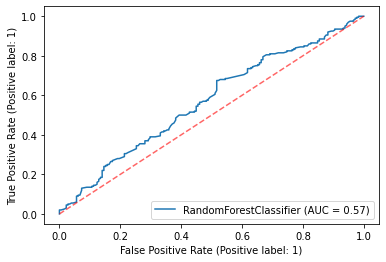

In [164]:
plot_roc_curve(model,X_val, test["Stock_change"])
plt.plot([0, 1], [0, 1], linestyle='--', color='r', alpha=.6)         
plt.show()

# Conclusion

The Prediction Of The NDX 100 Using World Headlines Only is probably insufficient, But it might be a useful feature with other factors that most experts believe to be highly inﬂuential on the stock market situation like Economic growth, market Stability, Related Stocks, etcetera.